# Orderings analysis

Here we implement an analysis where we make minigraphs showing the orderings of traits that evolve over the HuggingFace family trees.



In [1]:
import numpy as np
import pandas as pd
import pickle
import networkx as nx
import ast
from itertools import combinations
import matplotlib.pyplot as plt
from ordering_helpers import get_trait_list, get_trait_counter, get_trait_graph, append_total_appearances, get_trait_ratios, get_oriented_trait_graph, get_top_trait_graph, solve_max_compatible_ordering, solve_weighted_compatible_ordering, get_violating_edges, get_compatible_and_total_traffic
import random


In [2]:
# Use the full graph `ai_ecosystem_graph.pkl'
with open('data/ai_ecosystem_graph.pkl', 'rb') as f:
    G = pickle.load(f)

len(G.edges())

573653

In [3]:
#print a random node
print(G.nodes[random.choice(list(G.nodes()))])

{'likes': 1, 'downloads': 29, 'pipeline_tag': 'text-generation', 'library_name': 'transformers', 'createdAt': '2024-10-06T18:52:56.000Z', 'licenses': '[]', 'datasets': '[]', 'languages': '[]'}


## Top line statistics

In [4]:
language_mutations = 0
total_language_traffic = 0
license_mutations = 0
total_license_traffic = 0
library_mutations = 0
total_library_traffic = 0
task_mutations = 0
total_task_traffic = 0
counter = 0
for parent, child in G.edges():
    if counter % 100000 == 0:
        print(counter)
    counter += 1

    # Languages
    parent_languages = get_trait_list(G.nodes[parent], 'languages')
    child_languages = get_trait_list(G.nodes[child], 'languages')
    
    if not (parent_languages == [] or child_languages == []):
        union_languages = set(parent_languages).union(set(child_languages))
        intersection_languages = set(parent_languages).intersection(set(child_languages))
        
        if union_languages != intersection_languages:
            language_mutations += (len(union_languages) - len(intersection_languages)) / len(union_languages)
        
        total_language_traffic += 1

    # Licenses
    parent_licenses = get_trait_list(G.nodes[parent], 'licenses')
    child_licenses = get_trait_list(G.nodes[child], 'licenses')
    
    if not (parent_licenses == [] or child_licenses == []):
        union_licenses = set(parent_licenses).union(set(child_licenses))
        intersection_licenses = set(parent_licenses).intersection(set(child_licenses))

        if union_licenses != intersection_licenses:
            license_mutations += (len(union_licenses) - len(intersection_licenses)) / len(union_licenses)
        
        total_license_traffic += 1

    # Tasks
    parent_task = get_trait_list(G.nodes[parent], 'pipeline_tag')
    child_task = get_trait_list(G.nodes[child], 'pipeline_tag')
    
    if not (parent_task == [] or child_task == []):    
        union_tasks = set(parent_task).union(set(child_task))
        intersection_tasks = set(parent_task).intersection(set(child_task))

        if union_tasks != intersection_tasks:
            task_mutations += (len(union_tasks) - len(intersection_tasks)) / len(union_tasks)
        
        total_task_traffic += 1


0
100000
200000
300000
400000
500000


In [5]:
print("Language mutations: ", language_mutations)
print("Total language traffic: ", total_language_traffic)
print("Language mutation rate: ", language_mutations / total_language_traffic)
print()
print("License mutations: ", license_mutations)
print("Total license traffic: ", total_license_traffic) 
print("License mutation rate: ", license_mutations / total_license_traffic)
print()
print("Task mutations: ", task_mutations)
print("Total task traffic: ", total_task_traffic)
print("Task mutation rate: ", task_mutations / total_task_traffic)

Language mutations:  14809.58572353135
Total language traffic:  115660
Language mutation rate:  0.12804414424633712

License mutations:  47956.416666666664
Total license traffic:  320065
License mutation rate:  0.14983336718062476

Task mutations:  58091.0
Total task traffic:  251060
Task mutation rate:  0.23138293634987653


## Licenses

In [4]:
# Now let's try implementing for licenses

license_counter = get_trait_counter(G, 'licenses')

license_graph = get_trait_graph(G, 'licenses', license_counter)

In [5]:
# Sort license_counter by value
print( sorted(license_counter.items(), key=lambda x: x[1], reverse=True))

[('apache-2.0', 298442), ('mit', 109820), ('other', 81887), ('openrail', 37498), ('creativeml-openrail-m', 29233), ('cc-by-nc-4.0', 14315), ('llama2', 10294), ('llama3', 9887), ('gemma', 8677), ('unknown', 8368), ('llama3.1', 7614), ('cc-by-4.0', 6737), ('openrail++', 6552), ('llama3.2', 5863), ('cc-by-nc-sa-4.0', 3945), ('afl-3.0', 3657), ('cc-by-sa-4.0', 2984), ('gpl-3.0', 2875), ('artistic-2.0', 1942), ('llama3.3', 1849), ('cc', 1846), ('bigscience-bloom-rail-1.0', 1840), ('bigscience-openrail-m', 1742), ('bigcode-openrail-m', 1487), ('bsd-3-clause', 1363), ('cc-by-nc-nd-4.0', 1338), ('agpl-3.0', 969), ('wtfpl', 913), ('cc0-1.0', 779), ('unlicense', 754), ('bsd', 555), ('gpl', 523), ('bsl-1.0', 476), ('cc-by-sa-3.0', 408), ('bsd-2-clause', 324), ('cc-by-2.0', 298), ('cc-by-nc-2.0', 270), ('c-uda', 261), ('gpl-2.0', 216), ('cc-by-nd-4.0', 208), ('cdla-permissive-2.0', 203), ('cc-by-3.0', 196), ('llama4', 180), ('lgpl-3.0', 169), ('bsd-3-clause-clear', 167), ('cc-by-nc-3.0', 151), ('o

In [6]:
license_ratios = get_trait_ratios(license_graph, print_ratios=False)

oriented_license_graph = get_oriented_trait_graph(license_graph)
oriented_license_graph = append_total_appearances(oriented_license_graph, license_counter)
n = 20

top_license_graph = get_top_trait_graph(oriented_license_graph, n)

Removed 2 traits: ['other', 'unknown']


In [7]:
ordering_unweighted, compatible_count = solve_max_compatible_ordering(top_license_graph)
ordering_weighted, total_weight = solve_weighted_compatible_ordering(top_license_graph)
total_traffic = sum(data['traffic'] for _, _, data in top_license_graph.edges(data=True))
total_edges = top_license_graph.number_of_edges()
total_n = sum(data['total_n'] for _, _, data in top_license_graph.edges(data=True))

accounted_for_mutations_weightedordering, total_mutations = get_compatible_and_total_traffic(license_graph, ordering_weighted)

print(f"Ordering unweighted: {ordering_unweighted}")
print(f"Ordering weighted: {ordering_weighted}")
print(f"Total traffic: {total_traffic}")
print(f"Total n: {total_n}")
print(f"Compatible count: {compatible_count}")
print(f"Total edges: {total_edges}")
print(f"Total weight: {total_weight}")

print("Oriented graph compatibility: " + str(compatible_count) + " / " + str(total_edges) + " (" + str(compatible_count / total_edges) + ")")
print("Mutations accounted for: ", accounted_for_mutations_weightedordering / total_mutations)

Ordering unweighted: ['gemma', 'llama3.1', 'llama3.2', 'openrail++', 'creativeml-openrail-m', 'cc-by-nc-4.0', 'llama3', 'llama3.3', 'llama2', 'mit', 'afl-3.0', 'bigscience-bloom-rail-1.0', 'apache-2.0', 'cc-by-nc-sa-4.0', 'cc-by-4.0', 'openrail', 'artistic-2.0', 'cc-by-sa-4.0', 'gpl-3.0', 'cc']
Ordering weighted: ['gemma', 'llama3.1', 'llama3.2', 'openrail++', 'creativeml-openrail-m', 'cc-by-nc-4.0', 'llama3', 'llama2', 'mit', 'afl-3.0', 'bigscience-bloom-rail-1.0', 'llama3.3', 'apache-2.0', 'cc-by-nc-sa-4.0', 'cc-by-4.0', 'openrail', 'artistic-2.0', 'cc-by-sa-4.0', 'gpl-3.0', 'cc']
Total traffic: 47416
Total n: 68872
Compatible count: 132
Total edges: 140
Total weight: 47312.0
Oriented graph compatibility: 132 / 140 (0.9428571428571428)
Mutations accounted for:  0.8425635667014978


In [34]:
# Create a custom layout based on ordering_weighted
pos_custom = {}
x_values = random.sample(range(len(ordering_weighted)), len(ordering_weighted))
for i, node in enumerate(ordering_weighted):
    pos_custom[node] = (x_values[i], len(ordering_weighted) - i)


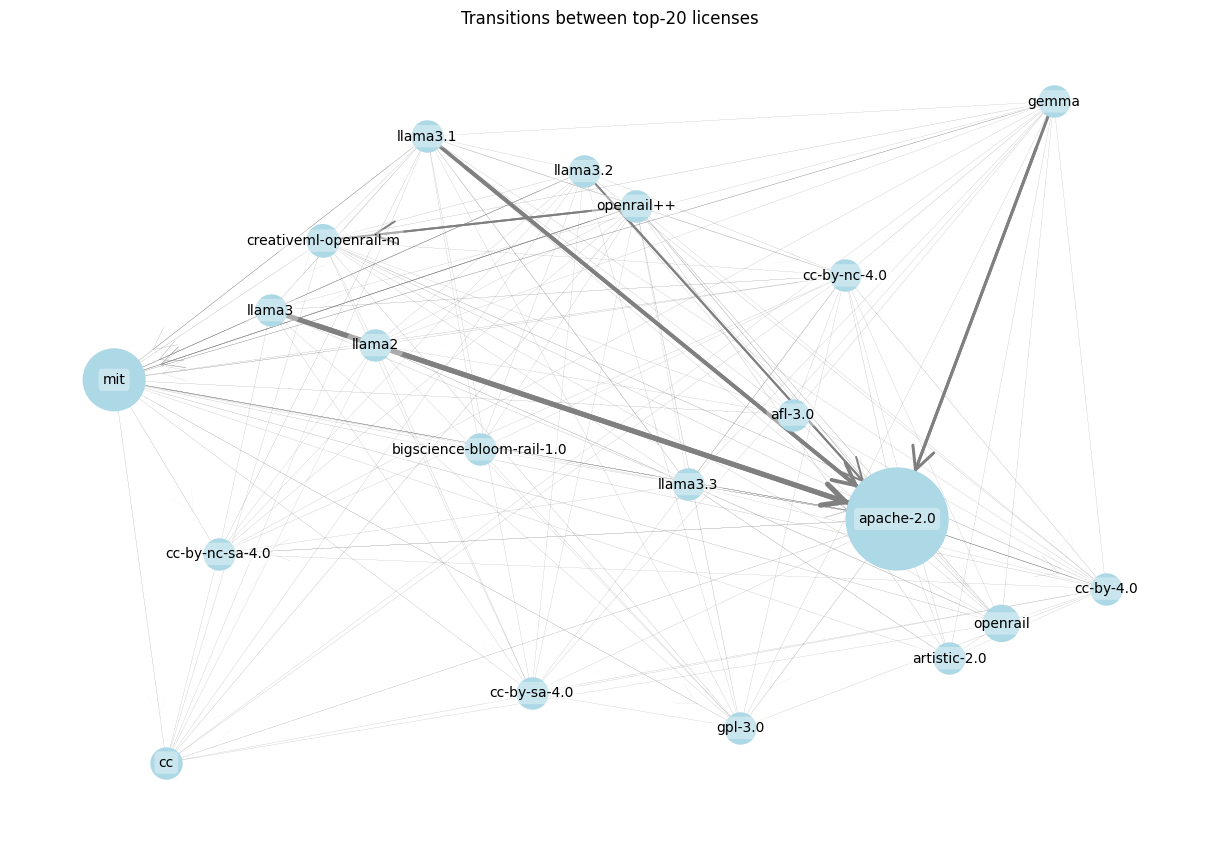

In [36]:

# Visualize the graph with the custom layout
plt.figure(figsize=(12, 8))
nx.draw(top_license_graph, pos_custom, with_labels=False, node_size=500, node_color="lightblue", font_size=10, font_weight="bold", edge_color="gray", width=0.1, arrowstyle='-')
nx.draw_networkx_nodes(top_license_graph, pos_custom, node_size=[top_license_graph.nodes[node]['total_appearances'] * 0.018 for node in top_license_graph.nodes()], node_color="lightblue")
nx.draw_networkx_edges(top_license_graph, pos_custom, node_size=1, arrowstyle='-', width=[top_license_graph[u][v]['traffic'] * 0.0003 for u, v in top_license_graph.edges()], edge_color="gray")
nx.draw_networkx_edges(top_license_graph, pos_custom, node_size=5000, arrowstyle='->', arrowsize=40, width=[top_license_graph[u][v]['traffic'] * 0.0003 for u, v in top_license_graph.edges()], edge_color="gray")

# Convert labels using the license_dict
label_list = [i for i in range(len(top_license_graph.nodes()))]
nx.draw_networkx_labels(top_license_graph, pos_custom, font_size=10, font_family="sans-serif",
                        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3', alpha=0.35))

plt.title("Transitions between top-{} licenses".format(n))
plt.savefig("figures/top_license_graph_customlayout_n{}.png".format(n), bbox_inches='tight', dpi=300)
plt.show()

## Languages

In [37]:
language_counter = get_trait_counter(G, 'languages')
language_graph = get_trait_graph(G, 'languages', language_counter)
language_ratios = get_trait_ratios(language_graph, print_ratios=False)

#print( sorted(language_counter.items(), key=lambda x: x[1], reverse=True))

In [38]:

# Given the optimal_ordering and the trait graph, get the total traffic among all nodes in the ordering, and the total traffic among all nodes compatible with the ordering
def get_compatible_and_total_traffic(trait_graph, optimal_ordering):
    total_traffic = 0
    total_traffic_compatible_with_ordering = 0
    for i in range(len(optimal_ordering)):
        for j in range(i+1, len(optimal_ordering)):
            if trait_graph.has_edge(optimal_ordering[j], optimal_ordering[i]):
                total_traffic += trait_graph[optimal_ordering[j]][optimal_ordering[i]]['transitions']
            if trait_graph.has_edge(optimal_ordering[i], optimal_ordering[j]):
                total_traffic += trait_graph[optimal_ordering[i]][optimal_ordering[j]]['transitions']
                total_traffic_compatible_with_ordering += trait_graph[optimal_ordering[i]][optimal_ordering[j]]['transitions']
    return total_traffic_compatible_with_ordering, total_traffic

#total_traffic, total_traffic_compatible_with_ordering = get_compatible_and_total_traffic(language_graph, ordering_weighted)

# Get the total traffic of the trait graph
#total_traffic_of_trait_graph = sum(data['traffic'] for _, _, data in trait_graph.edges(data=True))
#print(total_traffic_of_trait_graph)


In [39]:
oriented_language_graph = get_oriented_trait_graph(language_graph)
oriented_language_graph = append_total_appearances(oriented_language_graph, language_counter)

n = 20

top_language_graph = get_top_trait_graph(oriented_language_graph, n)

Removed 0 traits: []


In [40]:
ordering_unweighted, compatible_count = solve_max_compatible_ordering(top_language_graph)

ordering_weighted, total_weight = solve_weighted_compatible_ordering(top_language_graph)

total_traffic_top_traits = sum(data['traffic'] for _, _, data in top_language_graph.edges(data=True))
total_edges_top_traits = top_language_graph.number_of_edges()
total_n_top_traits = sum(data['total_n'] for _, _, data in top_language_graph.edges(data=True))

accounted_for_mutations_weightedordering, total_mutations = get_compatible_and_total_traffic(language_graph, ordering_weighted)

print(f"Ordering unweighted: {ordering_unweighted}")
print(f"Ordering weighted: {ordering_weighted}")
print(f"Total traffic: {total_traffic_top_traits}")
print(f"Total n: {total_n_top_traits}")
print(f"Compatible count: {compatible_count}")
print(f"Total edges: {total_edges_top_traits}")
print(f"Total weight: {total_weight}")

print("Oriented graph compatibility: " + str(compatible_count) + " / " + str(total_edges_top_traits) + " (" + str(compatible_count / total_edges_top_traits) + ")")
print("Mutations accounted for: ", accounted_for_mutations_weightedordering / total_mutations)

Ordering unweighted: ['Polish', 'Swedish', 'Thai', 'Italian', 'Portuguese', 'Japanese', 'Romanian', 'Dutch', 'German', 'Vietnamese', 'French', 'Indonesian', 'Turkish', 'Russian', 'Spanish', 'Chinese', 'Arabic', 'Hindi', 'Korean', 'English']
Ordering weighted: ['Polish', 'Swedish', 'Thai', 'Italian', 'Portuguese', 'Romanian', 'Dutch', 'German', 'French', 'Japanese', 'Indonesian', 'Vietnamese', 'Turkish', 'Russian', 'Spanish', 'Chinese', 'Arabic', 'Hindi', 'Korean', 'English']
Total traffic: 71772
Total n: 144898
Compatible count: 186
Total edges: 190
Total weight: 71688.0
Oriented graph compatibility: 186 / 190 (0.9789473684210527)
Mutations accounted for:  0.747084155750942


In [41]:
# Count all the weights on the edges in the graph
total_traffic_all_traits = sum(data['traffic'] for _, _, data in oriented_language_graph.edges(data=True))
total_edges_all_traits = oriented_language_graph.number_of_edges()
total_n_all_traits = sum(data['total_n'] for _, _, data in oriented_language_graph.edges(data=True))

print(f"Total traffic (all traits): {total_traffic_all_traits}")
print(f"Total n (all traits): {total_n_all_traits}")
print(f"Total edges (all traits): {total_edges_all_traits}")


Total traffic (all traits): 536423
Total n (all traits): 808257
Total edges (all traits): 10695


In [42]:
# Create a custom layout based on ordering_weighted
pos_custom = {}
x_values = random.sample(range(len(ordering_weighted)), len(ordering_weighted))
for i, node in enumerate(ordering_weighted):
    pos_custom[node] = (x_values[i], len(ordering_weighted) - i)

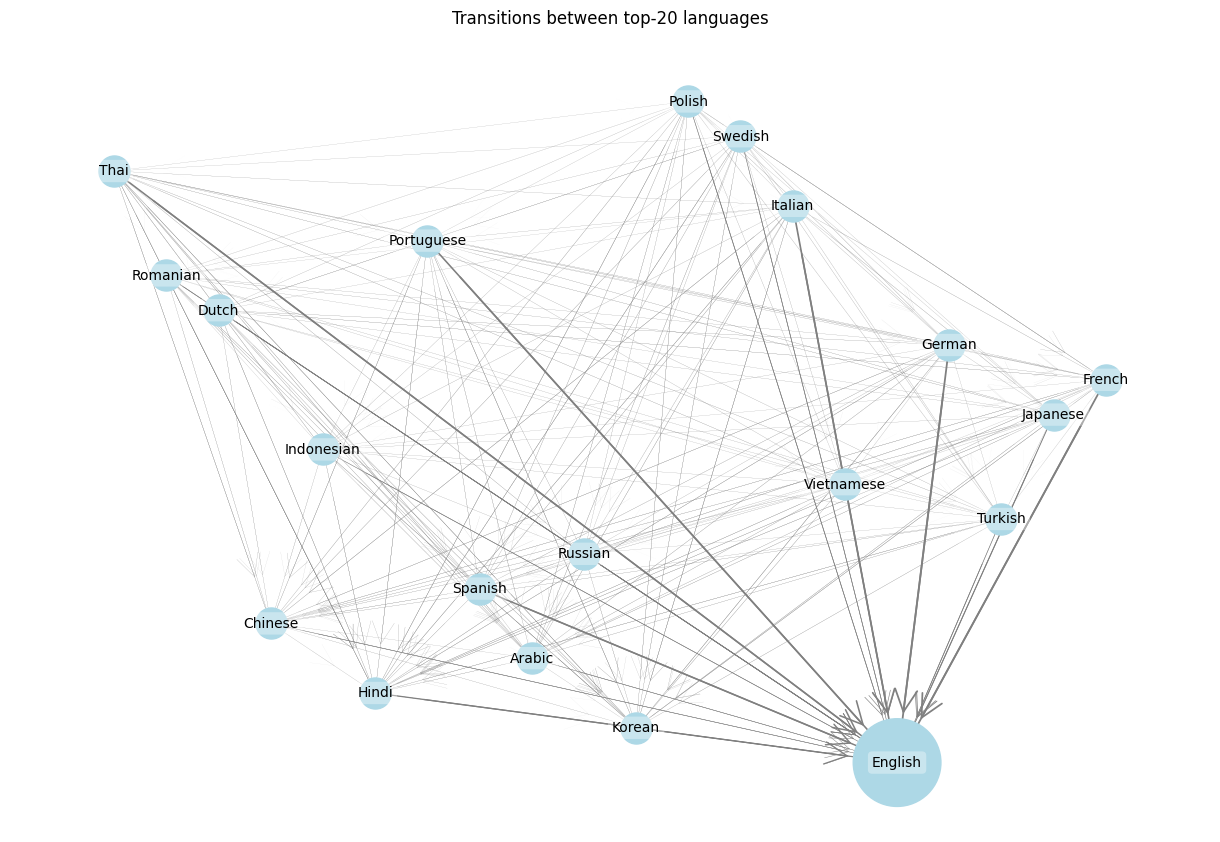

In [43]:
# Visualize the graph with the custom layout
plt.figure(figsize=(12, 8))
nx.draw(top_language_graph, pos_custom, with_labels=False, node_size=500, node_color="lightblue", font_size=10, font_weight="bold", edge_color="gray", width=0.1, arrowstyle='-')
nx.draw_networkx_nodes(top_language_graph, pos_custom, node_size=[top_language_graph.nodes[node]['total_appearances'] * 0.018 for node in top_language_graph.nodes()], node_color="lightblue")
nx.draw_networkx_edges(top_language_graph, pos_custom, node_size=1, arrowstyle='-', width=[top_language_graph[u][v]['traffic'] * 0.0003 for u, v in top_language_graph.edges()], edge_color="gray")
nx.draw_networkx_edges(top_language_graph, pos_custom, node_size=5000, arrowstyle='->', arrowsize=40, width=[top_language_graph[u][v]['traffic'] * 0.0003 for u, v in top_language_graph.edges()], edge_color="gray")

# Convert labels using the task_dict
label_list = [i for i in range(len(top_language_graph.nodes()))]
nx.draw_networkx_labels(top_language_graph, pos_custom, font_size=10, font_family="sans-serif",
                        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3', alpha=0.35))

plt.title("Transitions between top-{} languages".format(n))
#plt.savefig("figures/top_language_graph_customlayout_n{}.png".format(n), bbox_inches='tight', dpi=300)
plt.show()

# Libraries

In [44]:
library_counter = get_trait_counter(G, 'library_name')

library_graph = get_trait_graph(G, 'library_name', library_counter)

library_ratios = get_trait_ratios(library_graph, print_ratios=False)

#print(sorted(library_counter.items(), key=lambda x: x[1], reverse=True))

In [45]:
oriented_library_graph = get_oriented_trait_graph(library_graph)
oriented_library_graph = append_total_appearances(oriented_library_graph, library_counter)

n = 20

top_library_graph = get_top_trait_graph(oriented_library_graph, n)

Removed 0 traits: []


In [47]:
ordering_unweighted, compatible_count = solve_max_compatible_ordering(top_library_graph)

ordering_weighted, total_weight = solve_weighted_compatible_ordering(top_library_graph)

total_traffic = sum(data['traffic'] for _, _, data in top_library_graph.edges(data=True))
total_edges = top_library_graph.number_of_edges()
total_n = sum(data['total_n'] for _, _, data in top_library_graph.edges(data=True))

accounted_for_mutations_weightedordering, total_mutations = get_compatible_and_total_traffic(library_graph, ordering_weighted)

print(f"Ordering unweighted: {ordering_unweighted}")
print(f"Ordering weighted: {ordering_weighted}")
print(f"Total traffic: {total_traffic}")
print(f"Total n: {total_n}")
print(f"Compatible count: {compatible_count}")
print(f"Total edges: {total_edges}")
print(f"Total weight: {total_weight}")

print("Oriented graph compatibility: " + str(compatible_count) + " / " + str(total_edges) + " (" + str(compatible_count / total_edges) + ")")
print("Mutations accounted for: ", accounted_for_mutations_weightedordering / total_mutations)

Ordering unweighted: ['timm', 'transformers', 'spacy', 'sentence-transformers', 'mlc-llm', 'pytorch', 'lerobot', 'diffusers', 'adapter-transformers', 'peft', 'mlx', 'ml-agents', 'transformers.js', 'espnet', 'tf-keras', 'fastai', 'keras', 'setfit', 'flair', 'bertopic']
Ordering weighted: ['timm', 'transformers', 'spacy', 'sentence-transformers', 'mlc-llm', 'pytorch', 'lerobot', 'diffusers', 'adapter-transformers', 'peft', 'mlx', 'ml-agents', 'transformers.js', 'espnet', 'tf-keras', 'fastai', 'keras', 'setfit', 'flair', 'bertopic']
Total traffic: 399982
Total n: 405954
Compatible count: 43
Total edges: 43
Total weight: 399982.0
Oriented graph compatibility: 43 / 43 (1.0)
Mutations accounted for:  0.9926444868137769


In [48]:
# Create a custom layout based on ordering_weighted
pos_custom = {}
x_values = random.sample(range(len(ordering_weighted)), len(ordering_weighted))
for i, node in enumerate(ordering_weighted):
    pos_custom[node] = (x_values[i], len(ordering_weighted) - i)

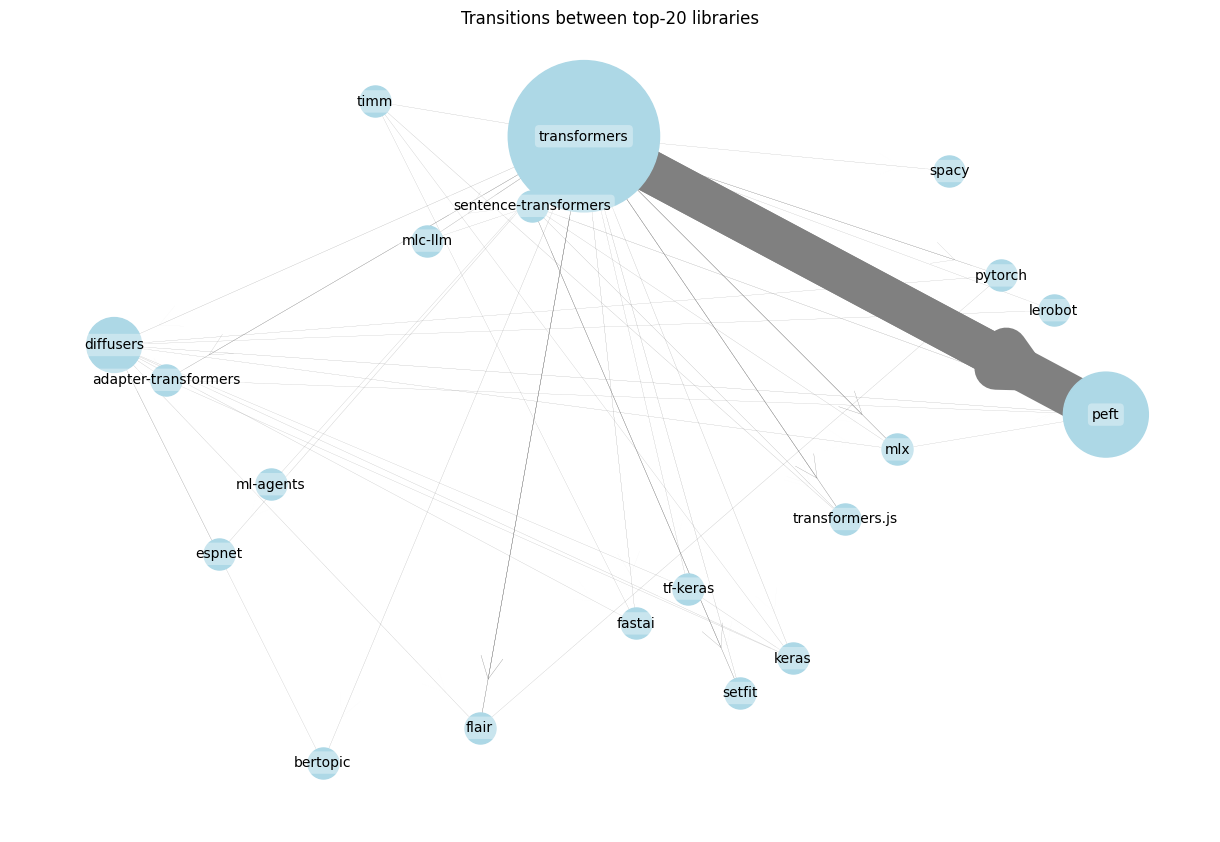

In [49]:
# Visualize the graph with the custom layout
plt.figure(figsize=(12, 8))
nx.draw(top_library_graph, pos_custom, with_labels=False, node_size=500, node_color="lightblue", font_size=10, font_weight="bold", edge_color="gray", width=0.1, arrowstyle='-')
nx.draw_networkx_nodes(top_library_graph, pos_custom, node_size=[top_library_graph.nodes[node]['total_appearances'] * 0.018 for node in top_library_graph.nodes()], node_color="lightblue")
nx.draw_networkx_edges(top_library_graph, pos_custom, node_size=1, arrowstyle='-', width=[top_library_graph[u][v]['traffic'] * 0.00008 for u, v in top_library_graph.edges()], edge_color="gray")
nx.draw_networkx_edges(top_library_graph, pos_custom, node_size=5000, arrowstyle='->', arrowsize=40, width=[top_library_graph[u][v]['traffic'] * 0.00008 for u, v in top_library_graph.edges()], edge_color="gray")

# Convert labels using the task_dict
label_list = [i for i in range(len(top_library_graph.nodes()))]
nx.draw_networkx_labels(top_library_graph, pos_custom, font_size=10, font_family="sans-serif",
                        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3', alpha=0.35))

plt.title("Transitions between top-{} libraries".format(n))
#plt.savefig("figures/top_library_graph_customlayout_n{}.png".format(n), bbox_inches='tight', dpi=300)
plt.show()

# Tasks

In [65]:
task_counter = get_trait_counter(G, 'pipeline_tag')
task_graph = get_trait_graph(G, 'pipeline_tag', task_counter)
task_ratios = get_trait_ratios(task_graph, print_ratios=False)

#print(sorted(task_counter.items(), key=lambda x: x[1], reverse=True))

In [81]:
oriented_task_graph = get_oriented_trait_graph(task_graph)
oriented_task_graph = append_total_appearances(oriented_task_graph, task_counter)

n = 20

top_task_graph = get_top_trait_graph(oriented_task_graph, n)

Removed 0 traits: []


In [86]:
ordering_unweighted, compatible_count = solve_max_compatible_ordering(top_task_graph)

ordering_weighted, total_weight = solve_weighted_compatible_ordering(top_task_graph)

total_traffic = sum(data['traffic'] for _, _, data in top_task_graph.edges(data=True))
total_edges = top_task_graph.number_of_edges()
total_n = sum(data['total_n'] for _, _, data in top_task_graph.edges(data=True))

accounted_for_mutations_weightedordering, total_mutations = get_compatible_and_total_traffic(task_graph, ordering_weighted)

print(f"Ordering unweighted: {ordering_unweighted}")
print(f"Ordering weighted: {ordering_weighted}")
print(f"Total traffic: {total_traffic}")
print(f"Total n: {total_n}")
print(f"Compatible count: {compatible_count}")
print(f"Total edges: {total_edges}")
print(f"Total weight: {total_weight}")

print("Oriented graph compatibility: " + str(compatible_count) + " / " + str(total_edges) + " (" + str(compatible_count / total_edges) + ")")
print("Mutations accounted for: ", accounted_for_mutations_weightedordering / total_mutations)

Ordering unweighted: ['image-text-to-text', 'fill-mask', 'automatic-speech-recognition', 'text-generation', 'text-to-image', 'object-detection', 'any-to-any', 'reinforcement-learning', 'text-to-speech', 'feature-extraction', 'translation', 'image-classification', 'image-to-text', 'audio-to-audio', 'sentence-similarity', 'question-answering', 'summarization', 'text-classification', 'token-classification', 'audio-classification']
Ordering weighted: ['image-text-to-text', 'fill-mask', 'feature-extraction', 'automatic-speech-recognition', 'text-to-speech', 'translation', 'summarization', 'text-generation', 'text-to-image', 'object-detection', 'image-classification', 'image-to-text', 'any-to-any', 'sentence-similarity', 'question-answering', 'text-classification', 'reinforcement-learning', 'audio-to-audio', 'token-classification', 'audio-classification']
Total traffic: 94652
Total n: 104604
Compatible count: 111
Total edges: 121
Total weight: 94574.0
Oriented graph compatibility: 111 / 121 

In [87]:
total_traffic_all_traits = sum(data['traffic'] for _, _, data in oriented_task_graph.edges(data=True))
total_edges_all_traits = oriented_task_graph.number_of_edges()
total_n_all_traits = sum(data['total_n'] for _, _, data in oriented_task_graph.edges(data=True))

print(f"Total traffic (all traits): {total_traffic_all_traits}")
print(f"Total n (all traits): {total_n_all_traits}")
print(f"Total edges (all traits): {total_edges_all_traits}")

Total traffic (all traits): 105438
Total n (all traits): 116138
Total edges (all traits): 306


In [88]:
# Create a custom layout based on ordering_weighted
pos_custom = {}
x_values = random.sample(range(len(ordering_weighted)), len(ordering_weighted))
for i, node in enumerate(ordering_weighted):
    pos_custom[node] = (x_values[i], len(ordering_weighted) - i)

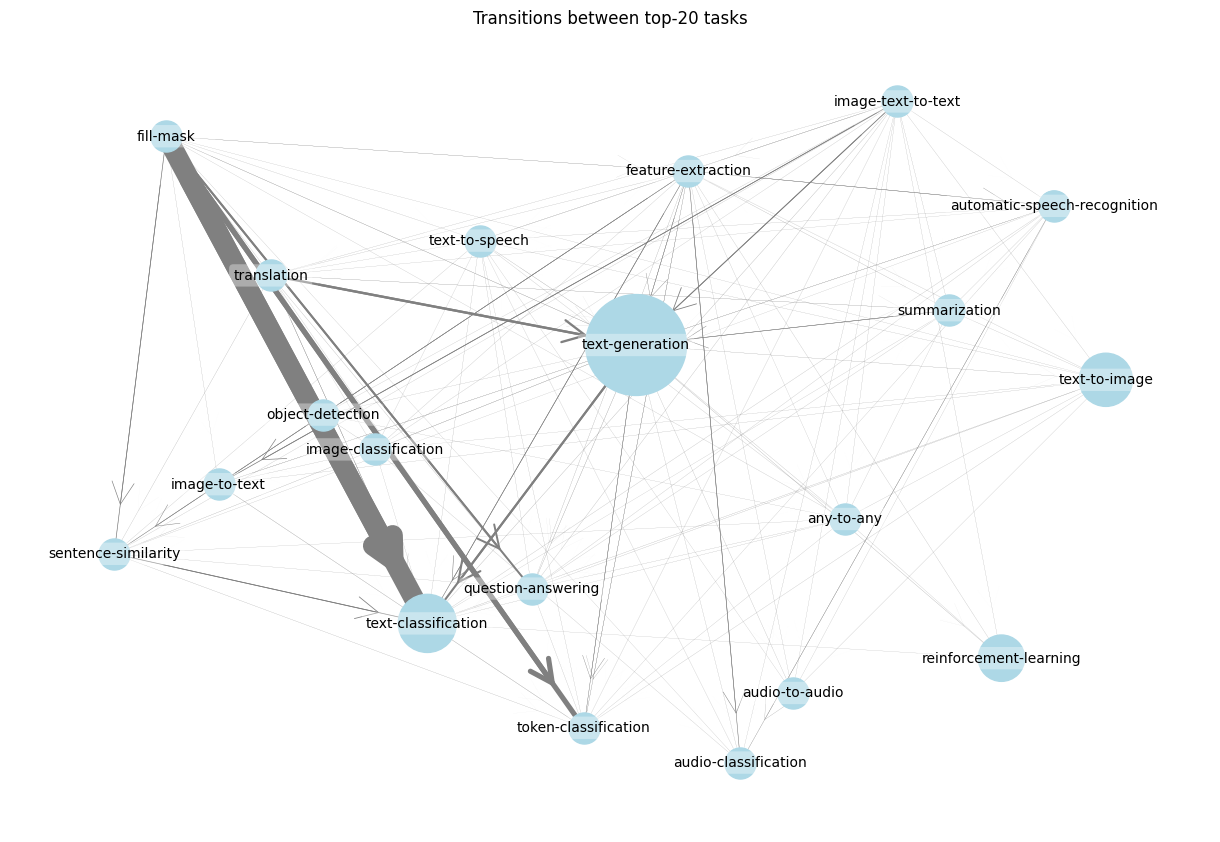

In [89]:
# Visualize the graph with the custom layout
plt.figure(figsize=(12, 8))
nx.draw(top_task_graph, pos_custom, with_labels=False, node_size=500, node_color="lightblue", font_size=10, font_weight="bold", edge_color="gray", width=0.1, arrowstyle='-')
nx.draw_networkx_nodes(top_task_graph, pos_custom, node_size=[top_task_graph.nodes[node]['total_appearances'] * 0.018 for node in top_task_graph.nodes()], node_color="lightblue")
nx.draw_networkx_edges(top_task_graph, pos_custom, node_size=1, arrowstyle='-', width=[top_task_graph[u][v]['traffic'] * 0.0003 for u, v in top_task_graph.edges()], edge_color="gray")
nx.draw_networkx_edges(top_task_graph, pos_custom, node_size=5000, arrowstyle='->', arrowsize=40, width=[top_task_graph[u][v]['traffic'] * 0.0003 for u, v in top_task_graph.edges()], edge_color="gray")

# Convert labels using the task_dict
label_list = [i for i in range(len(top_task_graph.nodes()))]
nx.draw_networkx_labels(top_task_graph, pos_custom, font_size=10, font_family="sans-serif",
                        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3', alpha=0.35))

plt.title("Transitions between top-{} tasks".format(n))
#plt.savefig("figures/top_task_graph_customlayout_n{}.png".format(n), bbox_inches='tight', dpi=300)
plt.show()

## Configurable version

Here we implement a configurable version where we can drag around the nodes.

In [30]:
import dash
import dash_cytoscape as cyto
import networkx as nx
from dash import html

# Create a graph

# Convert to Cytoscape format
nodes = [{"data": {"id": node, "label": node}} for node in top_language_graph.nodes()]
edges = [{"data": {"source": u, "target": v}} for u, v in top_language_graph.edges()]

app = dash.Dash(__name__)
app.layout = html.Div([
    cyto.Cytoscape(
        id='cytoscape',
        elements=nodes + edges,
        style={'width': '100%', 'height': '600px'},
        layout={'name': 'cose'},  # use 'preset' for fixed, 'cose' for dynamic layout
        stylesheet=[
            {
                "selector": "node",
                "style": {
                    "content": "data(label)",
                    "text-valign": "center",
                    "color": "white",
                    "background-color": "#0074D9",
                    "width": 40,
                    "height": 40,
                    "font-size": "12px"
                }
            },
            {
                "selector": "edge",
                "style": {
                    "curve-style": "bezier",
                    "target-arrow-shape": "triangle",
                    "arrow-scale": 1,
                    "line-color": "#ccc",
                    "target-arrow-color": "#ccc"
                }
            }
        ]
    )
])

if __name__ == '__main__':
    app.run(debug=True)